<a href="https://colab.research.google.com/github/ap-1993/Trend-or-Momentum/blob/master/Autocorrelation_Testing_and_Strategy_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels.tsa.api as ts
import statsmodels.graphics.tsaplots as tsplots 
from datetime import date

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
def nature(tick,start_date, freq):
  """
  Given a ticker symbol(as string), start-date, the freq('D','W','M', 'A'),
  returns whether the series is mean_reverting 
  or trending for the given frequency for the given
  time-period on the basis of statistically significant 
  1 -lag autocorrelation. End date is taken to be present date.
  Returns: A string containing the nature and the autocorrelation 
  """
  df = pdr.data.DataReader(tick, start = start_date, end = str(date.today()), data_source = 'yahoo')
  df['returns'] = (np.log(df['Adj Close'])).diff()
  df = df.dropna()
  df = df[['returns']]
  
  if freq == 'D':

    ac = df['returns'].autocorr()
    if ac >= 1.96/np.sqrt(len(df)) or ac <= -1.96/np.sqrt(len(df)):
      if ac > 0:
        return "The return series is trending with daily autocorrelation of {}".format(str(ac))
      else:
        return "The return series is mean_reverting with daily autocorrelation of {}".format(str(ac))
    else:
      return "No statistically significant autocorrelation"
  
  elif freq == "W":
    df = df.resample(rule = 'W').last()
    ac = df['returns'].autocorr()
    if ac >= 1.96/np.sqrt(len(df)) or ac <= -1.96/np.sqrt(len(df)):
      if ac > 0:
        return "The return series is trending with weekly autocorrelation of {}".format(str(ac))
      else:
        return "The return series is mean_reverting with weekly autocorrelation of {}".format(str(ac))
    else:
      return "No statistically significant autocorrelation"

  elif freq == "M":
    df = df.resample(rule = 'M').last()
    ac = df['returns'].autocorr()
    if ac >= 1.96/np.sqrt(len(df)) or ac <= -1.96/np.sqrt(len(df)):
      if ac > 0:
        return "The return series is trending with monthly autocorrelation of {}".format(str(ac))
      else:
        return "The return series is mean_reverting with monthly autocorrelation of {}".format(str(ac))
    else:
      return "No statistically significant autocorrelation"

  else:
    df = df.resample(rule = 'A').last()
    ac = df['returns'].autocorr()
    if ac >= 1.96/np.sqrt(len(df)) or ac <= -1.96/np.sqrt(len(df)):
      if ac > 0:
        return "The return series is trending with annual autocorrelation of {}".format(str(ac))
      else:
        return "The return series is mean_reverting with annual autocorrelation of {}".format(str(ac))
    else:
      return "No statistically significant autocorrelation"
  


In [0]:
def index(list_of_stocks, start_date, freq):
  """
  Given a list of tickers, start date and frequency
  calculates whether the series are trending or mean-reverting
  Returns: A dataframe with ticker, nature of series, freq and autocorrelation.
  """
  list_tickers = []
  list_nature = []
  list_freq = []
  list_ac = []
  for i in list_of_stocks:    
    nat = nature(i,start_date, freq).split()
    if 'No' not in nat:
      list_tickers.append(i)
      list_nature.append(nat[4].capitalize())
      list_freq.append(freq)
      list_ac.append(np.float(nat[9]))
  return pd.DataFrame({"Ticker": list_tickers,
                       "Nature": list_nature,
                       "Frequency": list_freq
                       }, columns = ['Ticker', 'Nature', 'Frequency']).join(pd.Series(list_ac, name = "Auto-Correlation"))

In [0]:
auto_corrs = index(['AAPL', 'GOOG', 'MSFT', 'GC=F'], start_date='2000-01-01', freq = 'W')
auto_corrs

,Ticker,Nature,Frequency,Auto-Correlation
0,AAPL,Trending,W,0.074878
1,MSFT,Mean_reverting,W,-0.106298


This means on the weekly level only MSFT and AAPL show statistically significant lag-1 auto-correlation. 
 

*   Negative autocorrelation means mean-reversion
*   Positive autocorrelation means trending



#Back Testing the correlation using a momentum and mean-reverting strategy

In [0]:
df = pdr.data.DataReader(["AAPL", "MSFT"], 
                       start='2000-1-1', 
                       end = str(date.today()), 
                       data_source='yahoo')['Adj Close']

In [0]:
df.index = pd.to_datetime(df.index)
df = df.resample(rule = 'W').last()
df.head()

Symbols,AAPL,MSFT
Date,,
2000-01-09,3.076317,35.650139
2000-01-16,3.105303,35.910065
2000-01-23,3.441533,33.190834
2000-01-30,3.142018,31.431328
2000-02-06,3.339118,34.090569


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9112d95da0>,
      dtype=object)

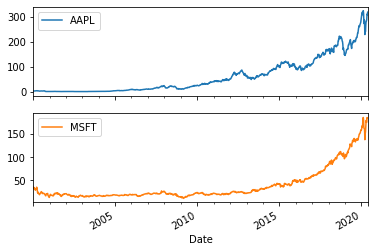

In [0]:
df.plot(subplots = True)

In [0]:
df['appl_returns'] = df['AAPL'].pct_change()
df['msft_returns'] = df['MSFT'].pct_change()

In [0]:
df.head()

Symbols,AAPL,MSFT,appl_returns,msft_returns
Date,,,,
2000-01-09,3.076317,35.650139,NaN,NaN
2000-01-16,3.105303,35.910065,0.009422,0.007291
2000-01-23,3.441533,33.190834,0.108276,-0.075723
2000-01-30,3.142018,31.431328,-0.087030,-0.053012
2000-02-06,3.339118,34.090569,0.062731,0.084605


In [0]:
aapl_signal = [1  if df.iloc[i-1,2] > 0 else -1 for i in range(len(df))] #if previous week return is positive I buy and if negative I sell
msft_signal =  [-1  if df.iloc[i-1,3] > 0 else 1 for i in range(len(df))]# if previous week return is positive I sell and if negative I buy

In [0]:
aapl_signal = pd.Series(aapl_signal, dtype = 'int', index=df.index, name = 'aapl_signal')
msft_signal = pd.Series(msft_signal, dtype = 'int', index=df.index, name = 'msft_signal')

In [0]:
df = pd.concat([df,aapl_signal, msft_signal], axis = 1)
df = df.dropna()
df.head()

,AAPL,MSFT,appl_returns,msft_returns,aapl_signal,msft_signal
Date,,,,,,
2000-01-16,3.105303,35.910065,0.009422,0.007291,-1,1
2000-01-23,3.441533,33.190834,0.108276,-0.075723,1,-1
2000-01-30,3.142018,31.431328,-0.087030,-0.053012,1,1
2000-02-06,3.339118,34.090569,0.062731,0.084605,-1,1
2000-02-13,3.362307,31.971157,0.006944,-0.062170,1,-1


In [0]:
df['Net_cashflow'] = df['AAPL']*df['aapl_signal'] + df['MSFT']*df['msft_signal']

In [0]:
df['return'] = df['Net_cashflow'].cumsum()

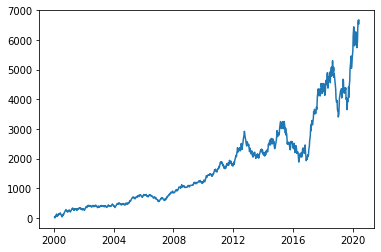

In [0]:
plt.plot(df['return'])

Eventhough the strategy returns seem very good, however there are huge transaction costs involved in this strategy that might bring down the total returns.
